### KSCHOOL DATA SCIENCE CHALLENGE
#### Simulated recruiting exercise
This notebook contains the code to solve a total of 5 exercises of a simulated recruiting process for a data scientist.
The input data are csv files containing information of commercial airlines and flights.

The packages necessary to run this notebook can be installed using the requirements.txt file, by running "$ conda create --name <env> --file <this file>" in the command line

### Exercise 1
#### Count the number of lines in Python for each file
The files are too big to open with pandas so I read them line by line

In [4]:
import os
import bz2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
from neobase import NeoBase

In [5]:
pd.options.mode.chained_assignment = None

In [6]:
searches_lines = 0
with bz2.open(os.path.join('data', 'searches.csv.bz2')) as file:
    for line in file.readlines():
        searches_lines +=1
print('lines in searches.csv: ', searches_lines)

book_lines = 0
with bz2.open(os.path.join('data', 'bookings.csv.bz2')) as file:
    for line in file.readlines():
        book_lines +=1
print('lines in bookings.csv: ', book_lines)

lines in searches.csv:  20390199
lines in bookings.csv:  10000011


### Exercise 2
#### Find the top 10 arrival airports in the world in 2013 (using the bookings file)
I need to find which ones were the airports where more people arrived in 2013. The total amount of passengers is obtained by adding up the column 'pax'. The arrival airport corresponds to column 'arr_port'.

#### Solving the problem in a sample

In [7]:
import pandas as pd
bookings_sample = pd.read_csv(os.path.join('data', 'bookings.csv.bz2'), sep ='^', nrows=200000)
pd.options.display.max_columns = None


In [8]:
bookings_sample.columns

Index(['act_date           ', 'source', 'pos_ctry', 'pos_iata', 'pos_oid  ',
       'rloc          ', 'cre_date           ', 'duration', 'distance',
       'dep_port', 'dep_city', 'dep_ctry', 'arr_port', 'arr_city', 'arr_ctry',
       'lst_port', 'lst_city', 'lst_ctry', 'brd_port', 'brd_city', 'brd_ctry',
       'off_port', 'off_city', 'off_ctry', 'mkt_port', 'mkt_city', 'mkt_ctry',
       'intl', 'route          ', 'carrier', 'bkg_class', 'cab_class',
       'brd_time           ', 'off_time           ', 'pax', 'year', 'month',
       'oid      '],
      dtype='object')

In [9]:
bookings_sample[bookings_sample['year']==2013].groupby('arr_port').sum()[['pax']].sort_values(by='pax', ascending=False).head(10)

,pax
arr_port,
LHR,1974
MCO,1731
LAS,1513
LAX,1458
JFK,1398
CDG,1376
SFO,1321
MIA,1291
BKK,1280


#### Solving the problem using chunks
I made first a toy problem with two chunks adding up to 20000 rows, so the solution should be the same as above.

In [10]:
bookings_sample = pd.read_csv(os.path.join('data', 'bookings.csv.bz2'), sep='^', nrows=20000, chunksize=10000)

I added up the amount of passengers in each chunk and saved it in a list

In [11]:
list_iterations = []
for chunk in bookings_sample:
    iteration = chunk[chunk['year']==2013].groupby('arr_port').sum()[['pax']]
    list_iterations.append(iteration)

Finally, I added up every chunk

In [12]:
data_concat = pd.concat(list_iterations).groupby('arr_port').sum()[['pax']]
data_concat.sort_values(by = 'pax', ascending = False).head(10)


,pax
arr_port,
JFK,195
MCO,192
LHR,182
ORD,173
LGA,160
LAX,154
PRG,154
EWR,149
SFO,147


#### Final solution

I repeated the code of the toy problem using all the data

In [13]:
bookings_sample = pd.read_csv(os.path.join('data', 'bookings.csv.bz2'), sep='^', chunksize=100000, low_memory=False)

In [14]:
list_iterations = []
for chunk in bookings_sample:
    iteration = chunk[chunk['year']==2013].groupby('arr_port').sum()[['pax']]
    list_iterations.append(iteration)

In [15]:
data_concat = pd.concat(list_iterations).groupby('arr_port').sum()[['pax']]
solution = data_concat.sort_values(by='pax', ascending=False).head(10)
display(solution)

,pax
arr_port,
LHR,88809.0
MCO,70930.0
LAX,70530.0
LAS,69630.0
JFK,66270.0
CDG,64490.0
BKK,59460.0
MIA,58150.0
SFO,58000.0


#### Bonus point: Get the name of the city or airport corresponding to that airport
I used the neobase library. With the function 'get', you can retrieve the name of the city from the code of the airport.

In [16]:
nb = NeoBase()
nb.get('ORY', 'city_name_list')[0]

'Paris'

I made a 'foor loop' to obtain a list of the city names

In [17]:
city_names = []
for city in solution.index:
    city_names.append(nb.get(city.strip(), 'city_name_list')[0])

In [18]:
city_names

['London',
 'Orlando',
 'Los Angeles',
 'Las Vegas',
 'New York City',
 'Paris',
 'Bangkok',
 'Miami',
 'San Francisco',
 'Dubai']

Then I added the city names to the solution tables

In [19]:
solution['city'] = city_names

In [20]:
display(solution)

,pax,city
arr_port,,
LHR,88809.0,London
MCO,70930.0,Orlando
LAX,70530.0,Los Angeles
LAS,69630.0,Las Vegas
JFK,66270.0,New York City
CDG,64490.0,Paris
BKK,59460.0,Bangkok
MIA,58150.0,Miami
SFO,58000.0,San Francisco


### Exercise 3
#### Plot the monthly number of searches for flights arriving at Málaga, Madrid or Barcelona on 2013. Plot a curve for each of the airports in the same figure
I needed to use the 'searches' csv file for this
Arriving airport can be found in the destination column

#### Solving the problem in a sample

In [21]:
searches_sample= pd.read_csv(os.path.join('data', 'searches.csv.bz2'), sep="^", nrows=60000)
searches_sample.columns

Index(['Date', 'Time', 'TxnCode', 'OfficeID', 'Country', 'Origin',
       'Destination', 'RoundTrip', 'NbSegments', 'Seg1Departure',
       'Seg1Arrival', 'Seg1Date', 'Seg1Carrier', 'Seg1BookingCode',
       'Seg2Departure', 'Seg2Arrival', 'Seg2Date', 'Seg2Carrier',
       'Seg2BookingCode', 'Seg3Departure', 'Seg3Arrival', 'Seg3Date',
       'Seg3Carrier', 'Seg3BookingCode', 'Seg4Departure', 'Seg4Arrival',
       'Seg4Date', 'Seg4Carrier', 'Seg4BookingCode', 'Seg5Departure',
       'Seg5Arrival', 'Seg5Date', 'Seg5Carrier', 'Seg5BookingCode',
       'Seg6Departure', 'Seg6Arrival', 'Seg6Date', 'Seg6Carrier',
       'Seg6BookingCode', 'From', 'IsPublishedForNeg', 'IsFromInternet',
       'IsFromVista', 'TerminalID', 'InternetOffice'],
      dtype='object')

I selected the necessary columns ('Date' and 'Destination'). From that dataframe I selected the relevant rows: those where destination is Madrid ('MAD'), Barcelona ('BCN') or Málaga ('AGP').

In [22]:
searches_sample_columns = searches_sample[['Date','Destination']]

In [23]:
searches_sample_columns_clean = searches_sample_columns[searches_sample_columns['Destination'].isin(('MAD','BCN','AGP'))]

In [24]:
searches_sample_columns_clean.head()

,Date,Destination
4,2013-01-01,MAD
93,2013-01-01,AGP
113,2013-01-01,BCN
147,2013-01-01,AGP
151,2013-01-01,MAD


I added a column to keep the counts

In [25]:
searches_sample_columns_clean['counter'] = 1
searches_sample_columns_clean.head()

,Date,Destination,counter
4,2013-01-01,MAD,1
93,2013-01-01,AGP,1
113,2013-01-01,BCN,1
147,2013-01-01,AGP,1
151,2013-01-01,MAD,1


Next, I extracted the month value from the date using the pandas method 'str'.

In [26]:
searches_sample_columns_clean['Date'] = searches_sample_columns_clean['Date'].str[5:7]

In [27]:
searches_sample_columns_clean

,Date,Destination,counter
4,01,MAD,1
93,01,AGP,1
113,01,BCN,1
147,01,AGP,1
151,01,MAD,1
...,...,...,...
59888,03,AGP,1
59942,03,MAD,1
59950,03,BCN,1
59961,03,MAD,1


Then, I obtained the solution using a 'groupby'

In [28]:
df_solution = searches_sample_columns_clean.groupby(['Destination','Date']).count().reset_index()

In [29]:
df_solution

,Destination,Date,counter
0,AGP,01,169
1,AGP,02,147
2,AGP,03,7
3,BCN,01,517
4,BCN,02,497
5,BCN,03,14
6,MAD,01,425
7,MAD,02,400
8,MAD,03,14


Text(0, 0.5, 'Number of reservations')

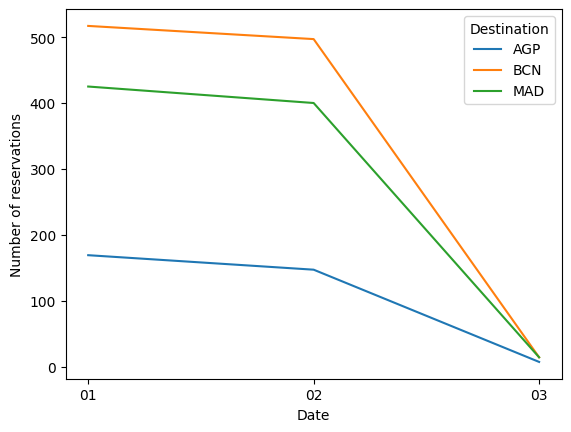

In [33]:
sns.lineplot(data=df_solution,x='Date',y='counter',hue='Destination')
plt.ylabel("Number of reservations")

#### Solving the exercise using chunks

In [34]:
searches = pd.read_csv(os.path.join('data', 'searches.csv.bz2'), sep="^", usecols=(['Date','Destination']), chunksize=50000)

I got the counts for each chunk in a 'for loop' and save them in a list

In [37]:
partial_results = []
for chunk in searches:
    chunk = chunk[['Date','Destination']]
    chunk_dest = chunk[chunk['Destination'].isin(('MAD','BCN','AGP'))]
    chunk_dest['Counter'] = 1
    chunk_dest['Date'] = chunk_dest['Date'].str[5:7]
    chunk_group = chunk_dest.groupby(['Destination','Date']).count().reset_index()
    partial_results.append(chunk_group)

Then I got the solution concatenating the items of the list, doing the groupby and the sum

In [38]:
total = pd.concat(partial_results).groupby(['Date','Destination']).sum()[['Counter']].reset_index()
total.head()

,Date,Destination,Counter
0,01,AGP,8450
1,01,BCN,25850
2,01,MAD,21280
3,02,AGP,7350
4,02,BCN,24850


Finally, I plotted the figure

Text(0, 0.5, 'Number of reservations')

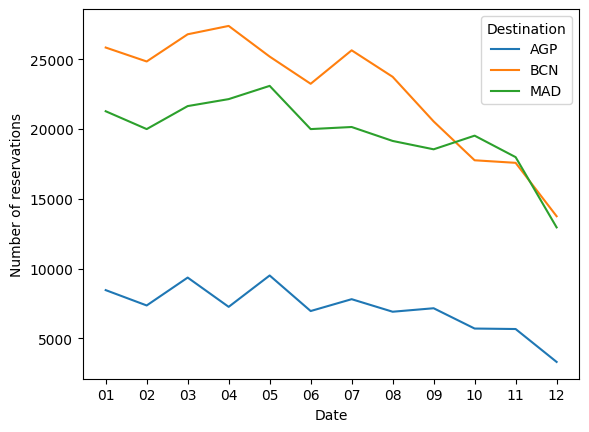

In [39]:
sns.lineplot(data=total, x='Date', y='Counter', hue='Destination')
plt.ylabel("Number of reservations")

### Exercise 4
#### Match searches with booking
For every search in the searches file, find out whether the search ended up in a booking or not.
For the bookings file, origin and destination are the columns dep_port and arr_port, respectively.
Generate a CSV file with the search data, and an additional field, containing 1 if the search ended up in a booking, and 0 otherwise.


##### Solving the problem in a sample

Opening and cleaning searches

In [40]:
searches = pd.read_csv(os.path.join('data', 'searches.csv.bz2'), 
                       sep="^", 
                       nrows = 100000, 
                       low_memory=False)

In [41]:
searches.head()

,Date,Time,TxnCode,OfficeID,Country,Origin,Destination,RoundTrip,NbSegments,Seg1Departure,Seg1Arrival,Seg1Date,Seg1Carrier,Seg1BookingCode,Seg2Departure,Seg2Arrival,Seg2Date,Seg2Carrier,Seg2BookingCode,Seg3Departure,Seg3Arrival,Seg3Date,Seg3Carrier,Seg3BookingCode,Seg4Departure,Seg4Arrival,Seg4Date,Seg4Carrier,Seg4BookingCode,Seg5Departure,Seg5Arrival,Seg5Date,Seg5Carrier,Seg5BookingCode,Seg6Departure,Seg6Arrival,Seg6Date,Seg6Carrier,Seg6BookingCode,From,IsPublishedForNeg,IsFromInternet,IsFromVista,TerminalID,InternetOffice
0,2013-01-01,20:25:57,MPT,624d8c3ac0b3a7ca03e3c167e0f48327,DE,TXL,AUH,1,2,TXL,AUH,2013-01-26,D2,NaN,AUH,TXL,2013-02-02,D2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1ASIWS,0,0,0,d41d8cd98f00b204e9800998ecf8427e,FRA
1,2013-01-01,10:15:33,MPT,b0af35b31588dc4ab06d5cf2986e8e02,MD,ATH,MIL,0,1,ATH,MIL,2013-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1ASIWS,0,0,0,d41d8cd98f00b204e9800998ecf8427e,KIV
2,2013-01-01,18:04:49,MPT,3561a60621de06ab1badc8ca55699ef3,US,ICT,SFO,1,2,ICT,SFO,2013-08-02,NaN,NaN,SFO,ICT,2013-08-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1ASIWS,0,0,0,d41d8cd98f00b204e9800998ecf8427e,NYC
3,2013-01-01,17:42:40,FXP,1864e5e8013d9414150e91d26b6a558b,SE,RNB,ARN,0,1,RNB,ARN,2013-01-02,DU,W,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1ASI,0,0,0,d41d8cd98f00b204e9800998ecf8427e,STO
4,2013-01-01,17:48:29,MPT,1ec336348f44207d2e0027dc3a68c118,NO,OSL,MAD,1,2,OSL,MAD,2013-03-22,NaN,NaN,MAD,OSL,2013-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1ASIWS,0,0,0,d41d8cd98f00b204e9800998ecf8427e,OSL


Select relevant columns in searches
We are going to match searches for a particular flight (date and itinerary) on a specific date  with bookings made for the same flight on that date. Hence, we select the columns that correspond to this information.

In [42]:
searches_select = searches[['Date', 'Seg1Date', 'Origin', 'Destination']]

In [43]:
searches_select.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Date         100000 non-null  object
 1   Seg1Date     99605 non-null   object
 2   Origin       100000 non-null  object
 3   Destination  100000 non-null  object
dtypes: object(4)
memory usage: 3.1+ MB


##### Opening and cleaning bookings

In [44]:
bookings = pd.read_csv(os.path.join('data', 'bookings.csv.bz2'),
                       sep="^",
                       nrows = 100000)

Cleaning column names

Column names are messed up, containing lots of empty spaces. I decide to rename the columns to make them easier to work with.

In [45]:
bookings_renamed = bookings.rename(columns={'cre_date           ': 'cre_date', 'brd_time           ': 'brd_time'})

Selecting relevant columns booking

As for the 'searches' file, I selected the columns with the info that corresponds to the date of reservation and the itinerary of the flight (date, origin and destination)

In [46]:
bookings_renamed_select = bookings_renamed[['cre_date', 'brd_time', 'arr_port', 'dep_port']]
bookings_renamed_select.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   cre_date  100000 non-null  object
 1   brd_time  100000 non-null  object
 2   arr_port  100000 non-null  object
 3   dep_port  100000 non-null  object
dtypes: object(4)
memory usage: 3.1+ MB


Reducing data complexity

Using the 'str' method I reduced the dates from a string containing date and hour to only the date. Arrival and departure airports needed to be reduced to the first the characters because there were empty spaces that made it impossible to match with the equivalent data in the 'searches' file.

In [47]:
bookings_renamed_select['cre_date'] = bookings_renamed_select['cre_date'].str[:10]
bookings_renamed_select['brd_time'] = bookings_renamed_select['brd_time'].str[:10]
bookings_renamed_select['arr_port'] = bookings_renamed_select['arr_port'].str[:3]
bookings_renamed_select['dep_port'] = bookings_renamed_select['dep_port'].str[:3]

Removing duplicates

By removing irrelevant columns I have generated many duplicates with the same dates, origin and destination, that's why I included a step to remove duplicates.

In [48]:
bookings_renamed_select_nodups = bookings_renamed_select.drop_duplicates(keep = 'first')

Renaming columns

I renamed the columns to match the name column in the 'searches' file. This made the merging of the files easier.

In [49]:
books = bookings_renamed_select_nodups.rename(columns={'cre_date':'Date', 'brd_time':'Seg1Date', 'arr_port':'Destination', 'dep_port':'Origin'})

In [50]:
books.info()

<class 'pandas.core.frame.DataFrame'>
Index: 66404 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Date         66404 non-null  object
 1   Seg1Date     66404 non-null  object
 2   Destination  66404 non-null  object
 3   Origin       66404 non-null  object
dtypes: object(4)
memory usage: 2.5+ MB


Function compiling all the cleaning made on 'bookings'

In [51]:
def clean_bookings(df):
    #rename columns
    renamed = df.rename(columns={'cre_date           ': 'Date', 
                                                'brd_time           ': 'Seg1Date', 
                                                'arr_port':'Destination', 
                                                'dep_port':'Origin'})
    #select columns
    selected = renamed[['Date', 'Seg1Date', 'Destination', 'Origin']]
    #reduce data complexity
    selected['Date'] = selected['Date'].str[:10]
    selected['Seg1Date'] = selected['Seg1Date'].str[:10]
    selected['Destination'] = selected['Destination'].str[:3]
    selected['Origin'] = selected['Origin'].str[:3]
    #remove duplicates
    clean_df = selected.drop_duplicates(keep = 'first')
    return clean_df
    

In [52]:
books_func = clean_bookings(bookings)
books_func.info()

<class 'pandas.core.frame.DataFrame'>
Index: 66404 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Date         66404 non-null  object
 1   Seg1Date     66404 non-null  object
 2   Destination  66404 non-null  object
 3   Origin       66404 non-null  object
dtypes: object(4)
memory usage: 2.5+ MB


Merging the files 'searches' and 'bookings'

I performed a left merge on the 'searches' dataframe, so the data on this dataframe remains. Thanks to the indicator, a new column named 'Booked' was generated that indicated wheter the same info was present (both) or not (left_only) in the 'bookings' dataframe.

In [53]:
merged_df = pd.merge(searches_select, books, 
                     on=['Date', 'Seg1Date', 'Origin', 'Destination'], 
                     how='left', 
                     indicator='Booked')

As asked by the problem statement, I changed the values of the 'Booked' column to 1 and 0.

In [54]:
merged_df['Booked'] = np.where(merged_df['Booked']=='both', 1, 0)

In [55]:
merged_df.describe()

,Booked
count,100000.00000
mean,0.00038
std,0.01949
min,0.00000
25%,0.00000
50%,0.00000
75%,0.00000
max,1.00000


Function that compiles the operations necessary for the merge

In [56]:
def merge_dataframes(df1, df2):
    merged_df = pd.merge(df1, df2, 
                     on=['Date', 'Seg1Date', 'Origin', 'Destination'], 
                     how='left', 
                     indicator='Booked')
    merged_df['Booked'] = np.where(merged_df['Booked']=='both', 1, 0)
    return merged_df

In [57]:
merge_dataframes(searches_select, books).describe()

,Booked
count,100000.00000
mean,0.00038
std,0.01949
min,0.00000
25%,0.00000
50%,0.00000
75%,0.00000
max,1.00000


##### Solving the problem using chunks

In order to resolve the problem using chunks, 'bookings' must be iterated for every chunk of 'searches', since I needed to check if every entry in 'searches'  was present in the whole 'bookings' dataset, not in a particular chunk.

This complicates the resolution of the problem because every 'searches' chunk is going to be matched several times. To solve this issue, I took the following approach. At the end of every 'bookings' loop, the merged dataframe of 'searches' and 'bookings' is concatenated sequencially. This generates a dataframe with multiple duplicates of two types:

- Entries that are not matched, so their value for 'Booked' is 0
- Entries that match in one chunk and not in others, so they have mixed 'Booked' values 1 and 0.

The cleaning of these duplicates is made with a function that selects this entries and removes the duplicates. This removal is made by index and not by value because I wanted to keep all data so I could add the column 'Booked' to the original 'searches' dataframe.

In [58]:
def cleaning_partial(df):
    # select entries that match in one chunk and not in others
    df_booked = df[(df.duplicated(['Date', 'Seg1Date', 'Origin', 'Destination', 'Booked'], keep=False))==False].sort_index()
    # change their 'Booked' values to 1 so they become perfect duplicates
    df_booked['Booked'] = 1
    # select entries that don't match
    df_notbooked = df[(df.duplicated(['Date', 'Seg1Date', 'Origin', 'Destination', 'Booked'], keep=False))==True].sort_index()
    # concat both kinds of entries
    df_clean = pd.concat([df_booked, df_notbooked])
    # clean duplicates by their indexes. 
    return df_clean[(df_clean.index.duplicated(keep='first'))==False].sort_index()

In [59]:
searches = pd.read_csv(os.path.join('data', 'searches.csv.bz2'),
                       sep="^",
                       nrows=100000,
                       chunksize=50000)

In [60]:
partial_results = []
for search_chunk in searches:
    #clean search_chunk
    search_chunk_clean = search_chunk[['Date', 'Seg1Date', 'Origin', 'Destination']]
    #load bookings
    bookings = pd.read_csv(os.path.join('data', 'bookings.csv.bz2'),
                       sep="^",
                       usecols=(['cre_date           ', 'brd_time           ', 'arr_port', 'dep_port']),
                       nrows = 100000,
                       chunksize=50000)
    partial_df = pd.DataFrame()
    for book_chunk in bookings:
        #clean bookings
        books = clean_bookings(book_chunk)
        
        #merge the searches chunk with the bookings chunk
        merged_df = merge_dataframes(search_chunk_clean, books)

        #concat bookings chunks
        partial_df = pd.concat([partial_df, merged_df])

    #removed duplicates from each searches chunk
    partial_result = cleaning_partial(partial_df)

    #add column to searches chunk
    search_chunk['Booked'] = list(partial_result['Booked'])

    partial_results.append(search_chunk)

In [61]:
result = pd.concat(partial_results)
result.describe()

,RoundTrip,NbSegments,IsPublishedForNeg,IsFromInternet,IsFromVista,Booked
count,100000.000000,100000.000000,100000.0,100000.0,100000.0,100000.00000
mean,0.704660,1.830380,0.0,0.0,0.0,0.00038
std,0.456198,0.718119,0.0,0.0,0.0,0.01949
min,0.000000,1.000000,0.0,0.0,0.0,0.00000
25%,0.000000,1.000000,0.0,0.0,0.0,0.00000
50%,1.000000,2.000000,0.0,0.0,0.0,0.00000
75%,1.000000,2.000000,0.0,0.0,0.0,0.00000
max,1.000000,10.000000,0.0,0.0,0.0,1.00000


##### Solving the problem using the entire datasets by writing directly to disc

This is the final solution to Exercise 4. In it, instead of saving the results in a list and then concatenat them, I concatenate them directly by writing into a csv file in mode 'a'.

First I needed to write the file with the header, then the loops will add iteratively the values for every chunk

In [65]:
searches = pd.read_csv(os.path.join('data', 'searches.csv.bz2'),
                       sep="^",
                       nrows=0)
searches['Booked'] = 1
searches.to_csv('solution.csv', index= False )

Then, the loops over the files begin

In [66]:
searches = pd.read_csv(os.path.join('data', 'searches.csv.bz2'),
                       sep="^",
                       chunksize=100000,
                       low_memory=False)

In [67]:
for search_chunk in searches:
    #clean search_chunk
    search_chunk_clean = search_chunk[['Date', 'Seg1Date', 'Origin', 'Destination']]
    #load bookings
    bookings = pd.read_csv(os.path.join('data', 'bookings.csv.bz2'),
                       sep="^",
                       usecols=(['cre_date           ', 'brd_time           ', 'arr_port', 'dep_port']),
                       chunksize=100000)
    partial_df = pd.DataFrame()
    for book_chunk in bookings:
        #clean bookings
        books = clean_bookings(book_chunk)
        
        #merge the searches chunk with the bookings chunk
        merged_df = merge_dataframes(search_chunk_clean, books)

        #concat bookings chunks
        partial_df = pd.concat([partial_df, merged_df])

    #removed duplicates from each searches chunk
    partial_result = cleaning_partial(partial_df)

    #add column to searches chunk
    search_chunk['Booked'] = list(partial_result['Booked'])

    search_chunk.to_csv('solution.csv', index=False, mode='a', header=False)

Checking the solution

In [68]:
solution = pd.read_csv('solution.csv', low_memory=False, nrows=10000)

In [69]:
solution.describe()

,RoundTrip,NbSegments,IsPublishedForNeg,IsFromInternet,IsFromVista,Booked
count,10000.000000,10000.000000,10000.0,10000.0,10000.0,10000.000000
mean,0.700700,1.833600,0.0,0.0,0.0,0.000600
std,0.457974,0.731823,0.0,0.0,0.0,0.024489
min,0.000000,1.000000,0.0,0.0,0.0,0.000000
25%,0.000000,1.000000,0.0,0.0,0.0,0.000000
50%,1.000000,2.000000,0.0,0.0,0.0,0.000000
75%,1.000000,2.000000,0.0,0.0,0.0,0.000000
max,1.000000,9.000000,0.0,0.0,0.0,1.000000


In [71]:
solution_lines = 0
with open(os.path.join('solution.csv')) as file:
    for line in file.readlines():
        solution_lines +=1
print('lines in solutions.csv: ', solution_lines)
print('Is the number of lines the same in solutions.csv and searches.csv: ', solution_lines == searches_lines)

lines in solutions.csv:  20390199
Is the number of lines the same in solutions.csv and searches.csv:  True


### Exercise 5
#### Write a Web Service
Wrap the output of the second exercise in a web service that returns the data in JSON format (instead of printing to the standard output).

This exercise was made with streamlit. The app 'exercise5.py' is an streamlit application where the parameters 'year' and 'number of airports' can be selected to obtain the table in json format as asked by the problem's statement. To run the app, run the command 'streamlit run exercise.py' in the command line.